In [ ]:
import pandas as pd
import numpy as np
# from scipy.sparse import csr_matrix, load_npz, save_npz, vstack
import seaborn as sns
import matplotlib.pyplot as plt
# import json
from concurrent.futures import ProcessPoolExecutor, as_completed
import anndata
import scanpy as sc
# from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
#from ALLCools.mcds.correlation import corr
from qnorm import quantile_normalize

In [ ]:
chunk_size = 3
cpu = 40
filter_corr= 0.3
mc_type = 'CHN'


## define

In [ ]:
#ArithmeticError#@njit
def _mean(a):
    n = len(a)
    b = np.empty(n)
    for i in range(n):
        b[i] = a[i].mean()
    return b


#@njit
def _std(a):
    n = len(a)
    b = np.empty(n)
    for i in range(n):
        b[i] = a[i].std()
    return b


#@njit
def _corr(a, b):
    """
    Correlation between rows in a and b, no nan value
    """
    n, k = a.shape
    m, k = b.shape
    
    mu_a = _mean(a)
    mu_b = _mean(b)
    sig_a = _std(a)
    sig_b = _std(b)

    out = np.empty((n, m))

    for i in range(n):
        for j in range(m):
            _sig_a = sig_a[i]
            _sig_b = sig_b[j]
            if _sig_a == 0 or _sig_b == 0:
                # if any variable std == 0
                out[i, j] = np.nan
            else:
                out[i, j] = (a[i] - mu_a[i]) @ (b[j] -
                                                mu_b[j]) / k / _sig_a / _sig_b
    return out


def corr(a, b, method='pearson'):
    if method.lower()[0] == 'p':
        pass
    elif method.lower()[0] == 's':
        # turn a, b in to rank matrix
        a = a.argsort(axis=1).argsort(axis=1)
        b = b.argsort(axis=1).argsort(axis=1)
    else:
        raise ValueError('Method can only be pearson or spearman')

    return _corr(a, b)

def get_corr_df(results, filter_corr):
    final_data = []
    for i in range(len(results)):
        final_data.append(pd.DataFrame(results[i])) 
    
    corr_df = pd.concat(final_data).T
    corr_df.index = rna_df.index
    corr_df.columns = mc_df.index
    
    filtered_corr_df = abs(corr_df) > filter_corr
    filtered_corr_df = filtered_corr_df.astype(int)
    
    return corr_df, filtered_corr_df


In [ ]:
rna_df = pd.read_csv('cluster_rna_matrix.csv', index_col = 0)
mc_df = pd.read_csv(f'{mc_type}_cluster_mc_frac_matrix.csv', index_col = 0)

In [ ]:
mc_df = mc_df.loc[rna_df.index]

## count corr

In [ ]:
cherry_genes = ['AT2G10940','AT4G30400','AT4G04610',
                'AT2G33380','AT1G57590','AT5G53450']

In [7]:
# rna_df = rna_df.loc[cherry_genes]
# mc_df = mc_df.loc[cherry_genes]

In [8]:
rna_df_array = np.array(rna_df)
mc_df_array = np.array(mc_df)

results = []
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for i, chunk_start in enumerate(range(0, mc_df_array.shape[0], chunk_size)):
        mc_data = mc_df_array[chunk_start:chunk_start+chunk_size, :]
        
        future = executor.submit(corr,
                                 a=mc_data, 
                                 b=rna_df_array, 
                                 )
        futures[future] = i

    results = {}
    for future in as_completed(futures):
        chunk_id = futures[future]
        masked_pass_record = future.result()
        results[chunk_id] = masked_pass_record

In [9]:
corr_df, filtered_corr_df = get_corr_df(results, filter_corr = filter_corr)

In [20]:
#corr_df.to_pickle(f"result/corr_{mc_type}.pkl")

## shuffle

In [11]:
def shuffle_within_sample(df):
    for sample in df.columns:
        np.random.shuffle(df[sample])
    
    return df

In [12]:
chunk_size = 50
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for i, chunk_start in enumerate(range(0, rna_df.shape[1], chunk_size)):
        tmpdf = rna_df.iloc[:,chunk_start:chunk_start+chunk_size]
    
        future = executor.submit(shuffle_within_sample,
                                 tmpdf)
        futures[future] = i

    results = {}
    for future in as_completed(futures):
        chunk_id = futures[future]
        masked_pass_record = future.result()
        results[chunk_id] = masked_pass_record
        
rna_df_s = pd.concat(results.values(), axis = 1)


In [13]:
chunk_size = 50

with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for i, chunk_start in enumerate(range(0, mc_df.shape[1], chunk_size)):
        tmpdf = mc_df.iloc[:,chunk_start:chunk_start+chunk_size]
    
        future = executor.submit(shuffle_within_sample,
                                 tmpdf)
        futures[future] = i

    results = {}
    for future in as_completed(futures):
        chunk_id = futures[future]
        masked_pass_record = future.result()
        results[chunk_id] = masked_pass_record
        
mc_df_s = pd.concat(results.values(), axis = 1)


In [14]:
rna_df_array = np.array(rna_df_s)
mc_df_array = np.array(mc_df_s)

results = []
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for i, chunk_start in enumerate(range(0, mc_df_array.shape[0], chunk_size)):
        mc_data = mc_df_array[chunk_start:chunk_start+chunk_size, :]
        
        future = executor.submit(corr,
                                 a=mc_data, 
                                 b=rna_df_array, 
                                 )
        futures[future] = i

    results = {}
    for future in as_completed(futures):
        chunk_id = futures[future]
        masked_pass_record = future.result()
        results[chunk_id] = masked_pass_record

In [15]:
s_corr_df, s_filtered_corr_df = get_corr_df(results, filter_corr = filter_corr)

In [21]:
s_corr_df.to_pickle(f"result/s_corr_{mc_type}.pkl")

## get result

In [ ]:
# corr_df = pd.read_pickle(f"result/corr_{mc_type}.pkl")
# s_corr_df = pd.read_pickle(f"result/s_corr_{mc_type}.pkl")

In [16]:
corr_df_diagonal_values = np.diag(corr_df.values)
s_corr_df_diagonal_values = np.diag(s_corr_df.values)

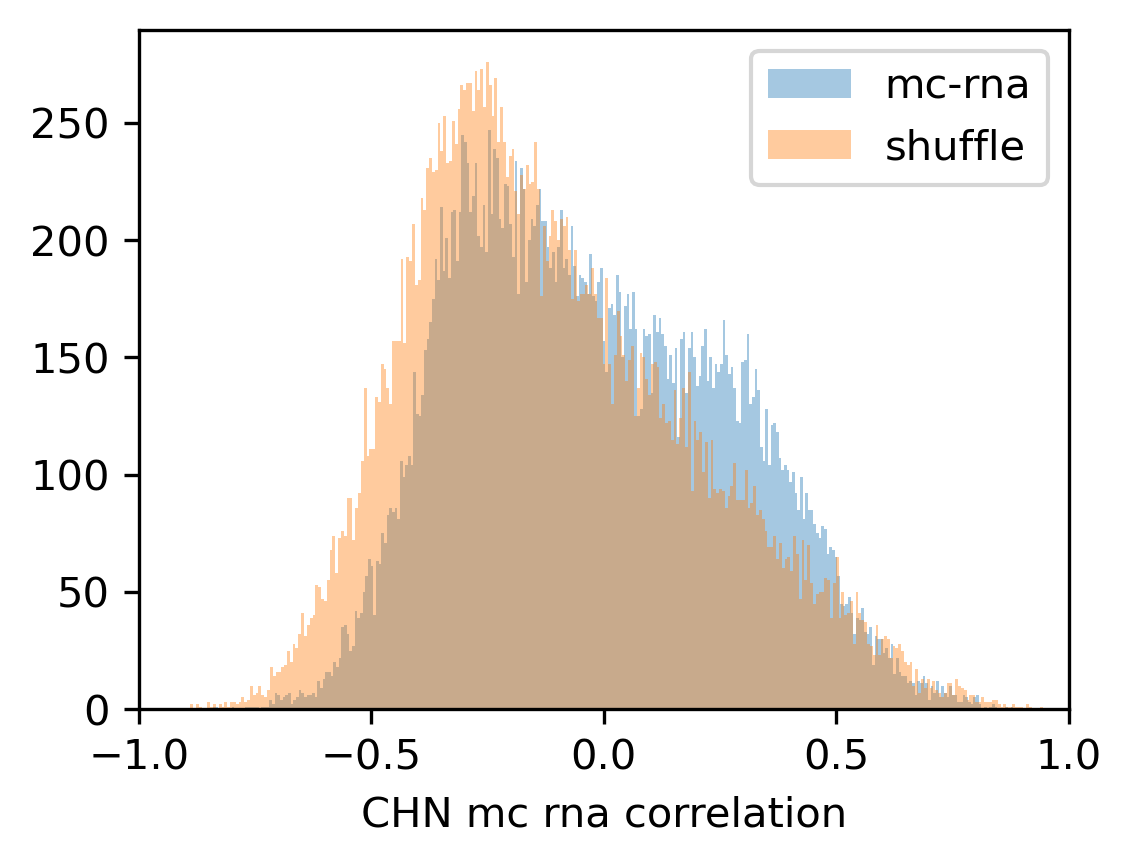

In [22]:
fig, ax = plt.subplots(figsize = (4,3), dpi = 300)
sns.distplot(corr_df_diagonal_values, ax = ax,kde=False,bins=300, label = 'mc-rna')
sns.distplot(s_corr_df_diagonal_values,ax = ax, kde=False,bins=300, label = 'shuffle')

ax.set_xlim(-1,1)
ax.set_xlabel(f'{mc_type} mc rna correlation')
plt.legend()
fig.savefig(f'{mc_type}_mc_rna_correlation.pdf', bbox_inches='tight')

In [ ]:
cg_corr_df = pd.read_pickle(f"result/corr_CGN.pkl")
ch_corr_df = pd.read_pickle(f"result/corr_CHN.pkl")

In [37]:
all_genes = []
all_cg_corr = []
all_ch_corr = []

for gene in cg_corr_df.columns:
    all_genes.append(gene)
    all_cg_corr.append(cg_corr_df.loc[gene,gene])
    all_ch_corr.append(ch_corr_df.loc[gene,gene])

In [53]:
mc_corr_df = pd.DataFrame({'cg_corr':all_cg_corr,
             'ch_corr':all_ch_corr}, index = all_genes)

In [61]:
mc_corr_df.to_csv('mc_rna_corr.csv')